In [714]:
# Abul Kalam Azad-12210325
# CS591-ML Assignment-2

# 1. Introduction

#### In this lab, given medical data were analyzed to identify patients at high risk of heart failure. Initially, given dataset analyzed, preprocessed. Then, Feature selection has performed for model development. To predict the death event, 3 different models developed by using K-Nearesr Neighbors (KNN), Decision Tree (DT), and Random Forest (RF) algorithms. The performance of each model including their confusion matrix generated for performance analysis. The KNN model achieved 93% accuracy where DT and RF has achieved 87% and 92% respectively. Also, KNN has no false negative cases.

In [715]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix

# 2. Dataset Familiarization

## Data Loading

In [716]:
# Load the dataset from github repository
given_dataset = "https://raw.githubusercontent.com/azad-nstu/CS591-ML-Assignment-2/main/Heart_failure_dataset.csv"
df = pd.read_csv(given_dataset)

## Data Exploration

In [717]:
# Given dataset shape
print(f'Data Frame Shape (rows, columns): {df.shape}')

Data Frame Shape (rows, columns): (299, 13)


In [718]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [719]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


# 3. Data Preprocessing

## Handling Missing Values

In [720]:
# Check Missing Values
Sum = df.isnull().sum()
Percentage = (df.isnull().sum()/df.isnull().count())
pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
age,0,0.0
anaemia,0,0.0
creatinine_phosphokinase,0,0.0
diabetes,0,0.0
ejection_fraction,0,0.0
high_blood_pressure,0,0.0
platelets,0,0.0
serum_creatinine,0,0.0
serum_sodium,0,0.0
sex,0,0.0


#### No missing values. So nothing to handle here.

In [721]:
# Target Variable count
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

Text(0.5, 1.0, 'DEATH_EVENT Count')

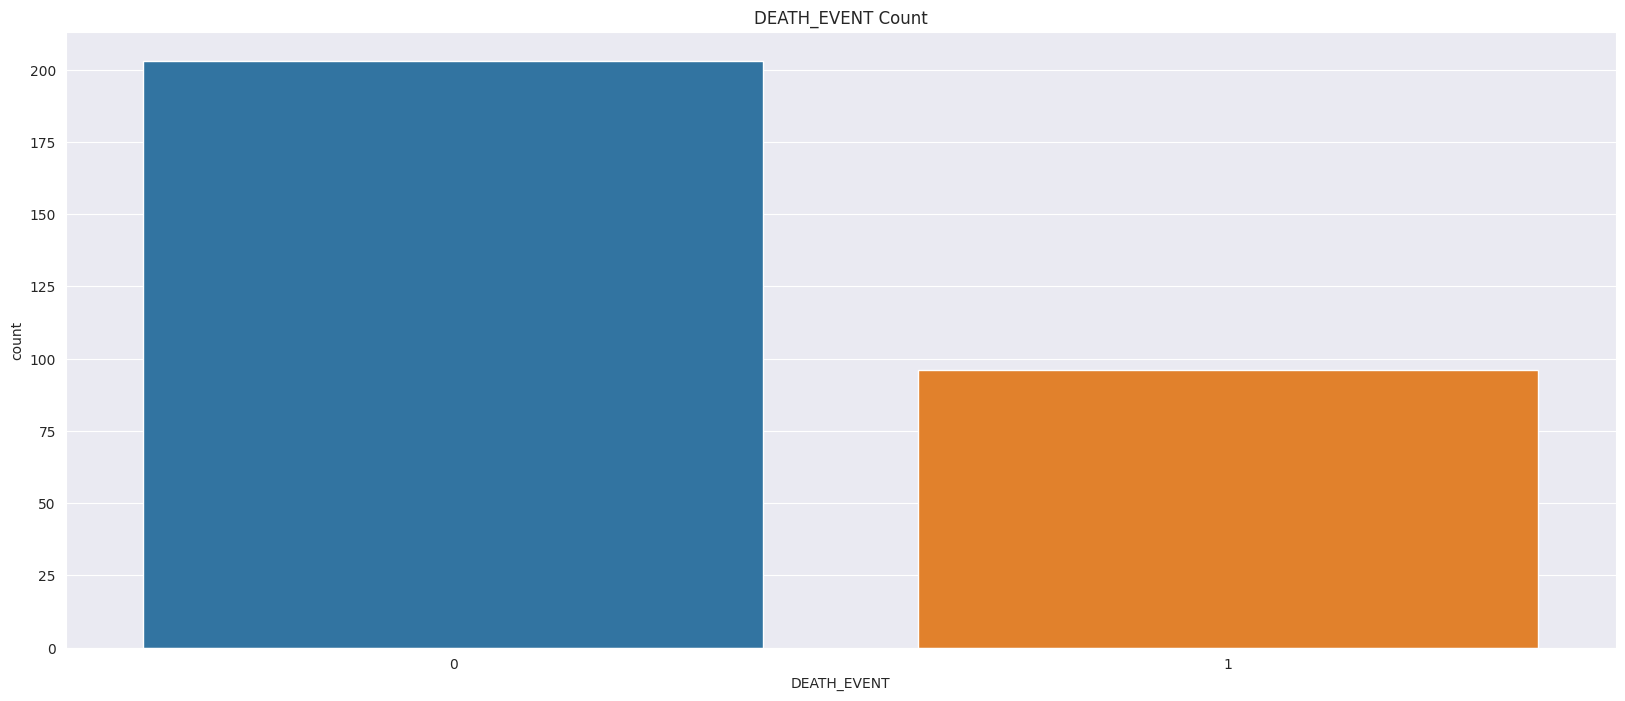

In [722]:
# Target Variable Visualization
sns.countplot(data=df, x="DEATH_EVENT").set_title("DEATH_EVENT Count")

#### DEATH_EVENT has 96 instances out of total 299 (around 33%) that is not bad. So, not going to upsample the minority class.

## Correlation Analysis

<Axes: >

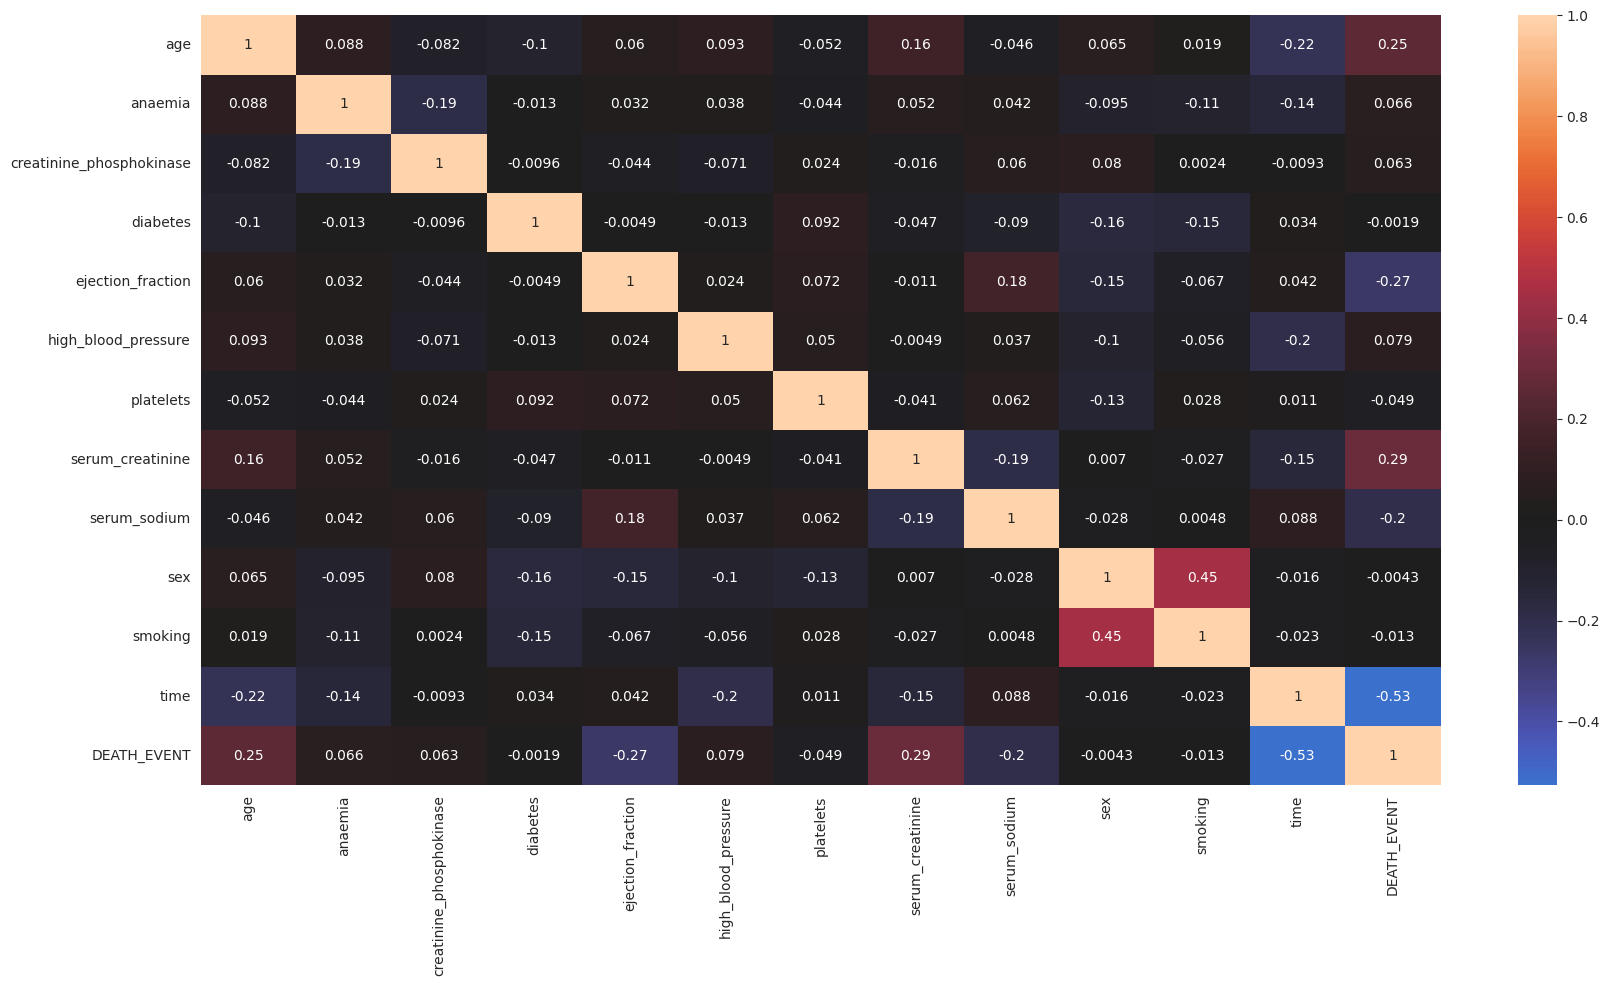

In [723]:
#Heatmap Correlation
cor = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(data=cor, annot=True, center=0)

Text(0, 0.5, 'correlation')

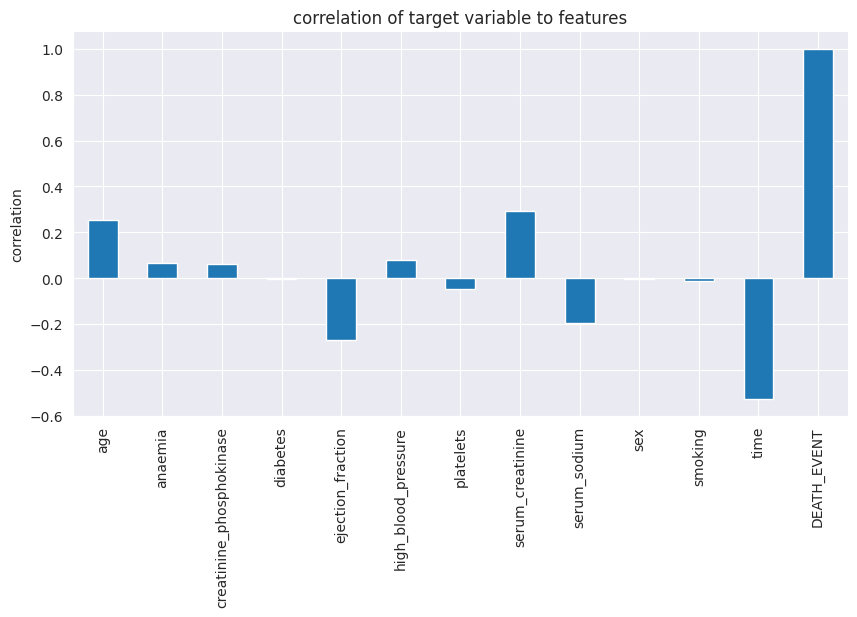

In [724]:
# Correlation
plt.figure(figsize=(10,5))
ax = df.corr()['DEATH_EVENT'].plot(kind='bar',title='correlation of target variable to features')
ax.set_ylabel('correlation')

In [725]:
cor["DEATH_EVENT"].sort_values(ascending=False)

DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64

#### Some features are highly correlated than the others. It might be effective for model development if we consider the highly correlated attributes only. So set the threshold 0.1 to select the attributes for model development.

In [726]:
# Select those attribute whose correlation score is >0.1
cor[abs(cor['DEATH_EVENT']) > 0.1]['DEATH_EVENT']

age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

#### Selected Attributes- 5 independent attributes were selected for model development that has high correlation with target variable

In [727]:
# Selected Independent Variablea: age, ejection_fraction, serum_creatinine, serum_sodium, time
# Target Variable: DEATH_EVENT
x = df[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']]
y = df['DEATH_EVENT']

## Split the dataset into Train and Test set. 80% for training, 20% for Testing

In [728]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.2)

# Model Development and Performance Evaluation- K-Nearest Neighbors, Decision Tree, and Random Forest Classifier


## K-Nearest Neighbors Classifier

### Without Optimization

In [729]:
# KNN model with Randomly selected K = 5
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn_model.fit(x_train, y_train.ravel())

KNeighborsClassifier()

In [730]:
train_accuracy = knn_model.score(x_train, y_train)
test_accuracy = knn_model.score(x_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy),
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 0.89
Accuracy in Test  set   : 0.88


In [731]:
print('KNN Model Performance for K=5:')
print('==================================')
yk_pred = knn_model.predict(x_test)
print('accuracy_score:  {:.2f}'.format(accuracy_score(y_pred=yk_pred,y_true=y_test.values.ravel())))
print('precision_score: {:.2f}'.format(precision_score(y_pred=yk_pred,y_true=y_test.ravel())))
print('recall:          {:.2f}'.format(recall_score(y_pred=yk_pred,y_true=y_test.ravel())))
print('F1:              {:.2f}'.format(f1_score(y_pred=yk_pred,y_true=y_test.ravel())))
print('AUC Score :      {:.2f}'.format(roc_auc_score(y_score=yk_pred,y_true=y_test.ravel())))

KNN Model Performance for K=5:
accuracy_score:  0.88
precision_score: 0.77
recall:          0.71
F1:              0.74
AUC Score :      0.82


### With Optimization

Text(0, 0.5, 'Accuracy')

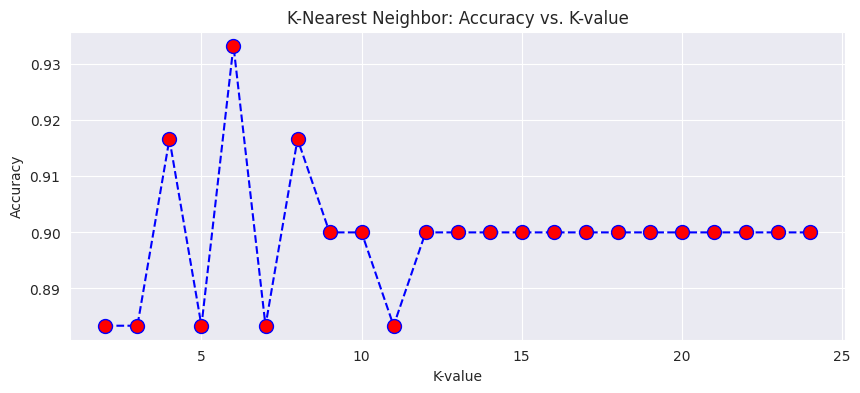

In [732]:
# Optimize K-value for Higher Accuracy
accuracy_knn = []
for i in range(2,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy_knn.append(accuracy_score(y_test,y_pred))

plt.figure(figsize=(10,4))
plt.plot(range(2,25), accuracy_knn, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('K-Nearest Neighbor: Accuracy vs. K-value')
plt.xlabel('K-value')
plt.ylabel('Accuracy')

#### Graph shows, for K= 6, the model accuracy is maximum. So will re-train the model with K=6

In [733]:
# Re-train model using optimal K-value
knn_model_opt = KNeighborsClassifier(n_neighbors=6)
knn_model_opt.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [734]:
train_accuracy = knn_model_opt.score(x_train, y_train)
test_accuracy = knn_model_opt.score(x_test, y_test)
print('Optimized Accuracy in Train set   : {:.2f}'.format(train_accuracy),
      'Optimized Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Optimized Accuracy in Train set   : 0.86
Optimized Accuracy in Test  set   : 0.93


In [735]:

print('Optimized KNN Model Performance for K = 6:')
print('=============================================')
yk_pred = knn_model_opt.predict(x_test)
print('accuracy_score:  {:.2f}'.format(accuracy_score(y_pred=yk_pred,y_true=y_test.values.ravel())))
print('precision_score: {:.2f}'.format(precision_score(y_pred=yk_pred,y_true=y_test.ravel())))
print('recall:          {:.2f}'.format(recall_score(y_pred=yk_pred,y_true=y_test.ravel())))
print('F1:              {:.2f}'.format(f1_score(y_pred=yk_pred,y_true=y_test.ravel())))
print('AUC Score :      {:.2f}'.format(roc_auc_score(y_score=yk_pred,y_true=y_test.ravel())))

Optimized KNN Model Performance for K = 6:
accuracy_score:  0.93
precision_score: 1.00
recall:          0.71
F1:              0.83
AUC Score :      0.86


### After optimization, accuracy improves from 88% to 93%

## Confusuin Matrix for KNN

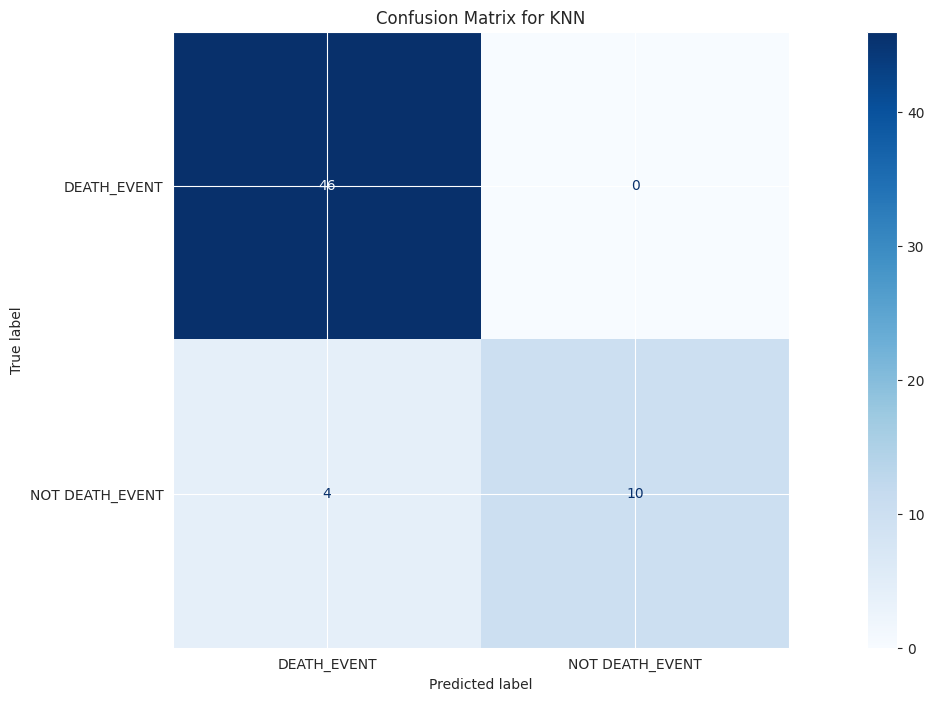

In [736]:
# Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, yk_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['DEATH_EVENT', 'NOT DEATH_EVENT'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title('Confusion Matrix for KNN')
plt.show()

### For KNN, Confusion matrix shows, False Negative = 0 that is very important in medical context because identify a patient with non-patient is very dangerous. Considering the accuracy and False negarive value, the KNN model performed best.

## Decision Tree Classifier

### Without Optimization

In [737]:
# Decision Tree model with default parameters
dec_model = DecisionTreeClassifier()
dec_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [738]:
train_accuracy = dec_model.score(x_train, y_train)
test_accuracy = dec_model.score(x_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy),
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 1.00
Accuracy in Test  set   : 0.83


In [739]:
print('Decision Tree Model Performance:')
print('===================================')
yd_pred = dec_model.predict(x_test)
print('accuracy_score:  {:.2f}'.format(accuracy_score(y_pred=yd_pred,y_true=y_test.values.ravel())))
print('precision_score: {:.2f}'.format(precision_score(y_pred=yd_pred,y_true=y_test.ravel())))
print('recall:          {:.2f}'.format(recall_score(y_pred=yd_pred,y_true=y_test.ravel())))
print('F1:              {:.2f}'.format(f1_score(y_pred=yd_pred,y_true=y_test.ravel())))
print('AUC Score :      {:.2f}'.format(roc_auc_score(y_score=yd_pred,y_true=y_test.ravel())))

Decision Tree Model Performance:
accuracy_score:  0.83
precision_score: 0.61
recall:          0.79
F1:              0.69
AUC Score :      0.82


### With Optimization

Text(0, 0.5, 'Accuracy')

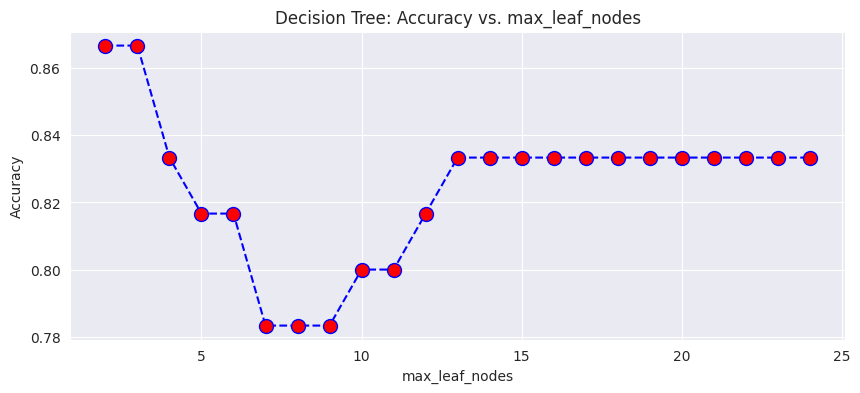

In [740]:
# Optimize max_leaf_nodes for Higher Accuracy
accuracy_dt = []
for i in range(2,25):
    dt = DecisionTreeClassifier(max_leaf_nodes = i, random_state=42)
    dt.fit(x_train, y_train)
    y_pred = dt.predict(x_test)
    accuracy_dt.append(accuracy_score(y_test,y_pred))

plt.figure(figsize=(10,4))
plt.plot(range(2,25), list1, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Decision Tree: Accuracy vs. max_leaf_nodes')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Accuracy')

#### Graph shows, for max_leaf_nodes = 2 and 3, the accuracy is maximum for the given dataset. So, will re-train the model for max_leaf_nodes = 3

In [741]:
# Decision Tree model with Optimized max_leaf_nodes = 3
dec_model_opt = DecisionTreeClassifier(max_leaf_nodes = 3, random_state=42)
dec_model_opt.fit(x_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)

In [742]:
train_accuracy = dec_model_opt.score(x_train, y_train)
test_accuracy = dec_model_opt.score(x_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy),
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 0.84
Accuracy in Test  set   : 0.87


In [743]:
print('Optimized Decision Tree Model Performance for max_leaf_nodes = 3:')
print('=======================================================================')
yd_pred = dec_model_opt.predict(x_test)
print('accuracy_score:  {:.2f}'.format(accuracy_score(y_pred=yd_pred,y_true=y_test.values.ravel())))
print('precision_score: {:.2f}'.format(precision_score(y_pred=yd_pred,y_true=y_test.ravel())))
print('recall:          {:.2f}'.format(recall_score(y_pred=yd_pred,y_true=y_test.ravel())))
print('F1:              {:.2f}'.format(f1_score(y_pred=yd_pred,y_true=y_test.ravel())))
print('AUC Score :      {:.2f}'.format(roc_auc_score(y_score=yd_pred,y_true=y_test.ravel())))

Optimized Decision Tree Model Performance for max_leaf_nodes = 3:
accuracy_score:  0.87
precision_score: 0.75
recall:          0.64
F1:              0.69
AUC Score :      0.79


#### For DT, after optimization, performance improved from 83% to 87%. However, I tried other combination of max_depth and max_leaf_nodes for further improvement but 87% is the highest accuracy that I achieved for the given dataset.

In [744]:
'''
#Test
param_grid = {
    'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
    'max_leaf_nodes': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,25]
}
ran_for_dt_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, verbose=3, cv=5, n_jobs=1, scoring = "accuracy")
ran_for_dt_search.fit(x_train, y_train.values.ravel())
ran_for_dt_search.best_params_
'''

'\n#Test\nparam_grid = {\n    \'max_depth\':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],\n    \'max_leaf_nodes\': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,25]\n}\nran_for_dt_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, verbose=3, cv=5, n_jobs=1, scoring = "accuracy")\nran_for_dt_search.fit(x_train, y_train.values.ravel())\nran_for_dt_search.best_params_\n'

In [745]:
dec_model_opt2 = DecisionTreeClassifier(max_depth = 2, max_leaf_nodes = 2, random_state=42)
dec_model_opt2.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=2, random_state=42)

In [746]:
yd_pred2 = dec_model_opt2.predict(x_test)
print('accuracy_score:  {:.2f}'.format(accuracy_score(y_pred=yd_pred2,y_true=y_test.values.ravel())))

accuracy_score:  0.87


## Confusion Matrix for DT

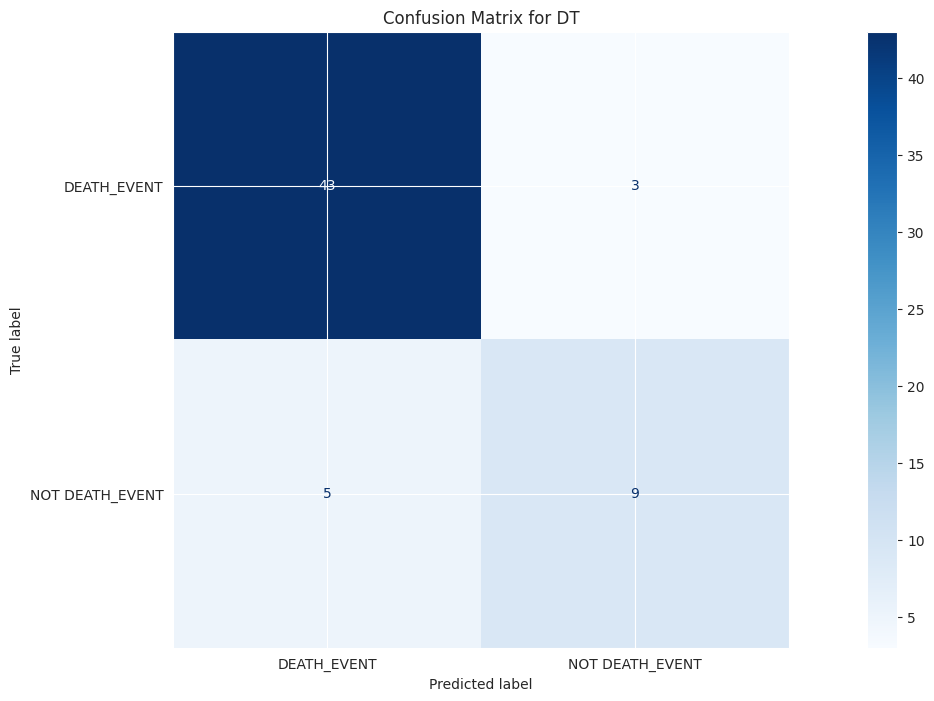

In [747]:
# Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, yd_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['DEATH_EVENT', 'NOT DEATH_EVENT'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title('Confusion Matrix for DT')
plt.show()

### DT offers lowest accuracy among 3 models. Also it has 3 instance of False Negative cases.

## Random Forest Classifier

## Without Optimization

In [748]:
# Random Forest model with default parameters
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [749]:
train_accuracy = rf_model.score(x_train, y_train)
test_accuracy = rf_model.score(x_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy),
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 1.00
Accuracy in Test  set   : 0.92


In [750]:
print('Random Forest Model Performance:')
print('=====================================')
yr_pred = rf_model.predict(x_test)
print('accuracy_score:  {:.2f}'.format(accuracy_score(y_pred=yr_pred,y_true=y_test.values.ravel())))
print('precision_score: {:.2f}'.format(precision_score(y_pred=yr_pred,y_true=y_test.ravel())))
print('recall:          {:.2f}'.format(recall_score(y_pred=yr_pred,y_true=y_test.ravel())))
print('F1:              {:.2f}'.format(f1_score(y_pred=yr_pred,y_true=y_test.ravel())))
print('AUC Score :      {:.2f}'.format(roc_auc_score(y_score=yr_pred,y_true=y_test.ravel())))

Random Forest Model Performance:
accuracy_score:  0.92
precision_score: 0.80
recall:          0.86
F1:              0.83
AUC Score :      0.90


### With Optimization

Text(0, 0.5, 'Accuracy')

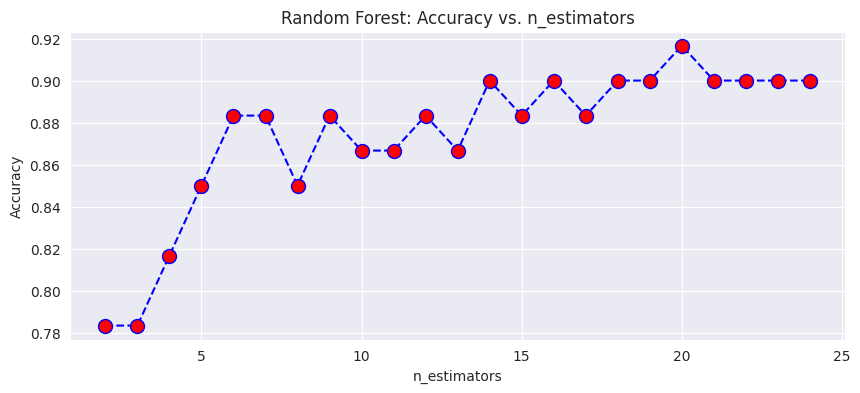

In [751]:
#Finding the optimum number of n_estimators
accuracy_rf = []
for estimators in range(2,25):
    classifier = RandomForestClassifier(n_estimators = estimators, random_state=42)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    accuracy_rf.append(accuracy_score(y_test,y_pred))

plt.figure(figsize=(10,4))
plt.plot(range(2,25), accuracy_rf, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Random Forest: Accuracy vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

#### For n_estimators = 20, the RF model for given dataset achieved highest accuracy. SO will try with n_estimators = 20

In [752]:
# Training the RandomForest Classifier on the Training set
rf_model_opt = RandomForestClassifier(n_estimators = 20, random_state=42)
rf_model_opt.fit(x_train,y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [753]:
train_accuracy = rf_model_opt.score(x_train, y_train)
test_accuracy = rf_model_opt.score(x_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy),
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 1.00
Accuracy in Test  set   : 0.92


In [754]:
print('Optimized Random Forest Model Performance for n_estimators = 20:')
print('=====================================================================')
yr_pred = rf_model_opt.predict(x_test)
print('accuracy_score:  {:.2f}'.format(accuracy_score(y_pred=yr_pred,y_true=y_test.values.ravel())))
print('precision_score: {:.2f}'.format(precision_score(y_pred=yr_pred,y_true=y_test.ravel())))
print('recall:          {:.2f}'.format(recall_score(y_pred=yr_pred,y_true=y_test.ravel())))
print('F1:              {:.2f}'.format(f1_score(y_pred=yr_pred,y_true=y_test.ravel())))
print('AUC Score :      {:.2f}'.format(roc_auc_score(y_score=yr_pred,y_true=y_test.ravel())))

Optimized Random Forest Model Performance for n_estimators = 20:
accuracy_score:  0.92
precision_score: 0.85
recall:          0.79
F1:              0.81
AUC Score :      0.87


#### Optimization didn't improve the performance but it remains the same as 92%. That is also satisfactory.

## Confusion Matrix for RF

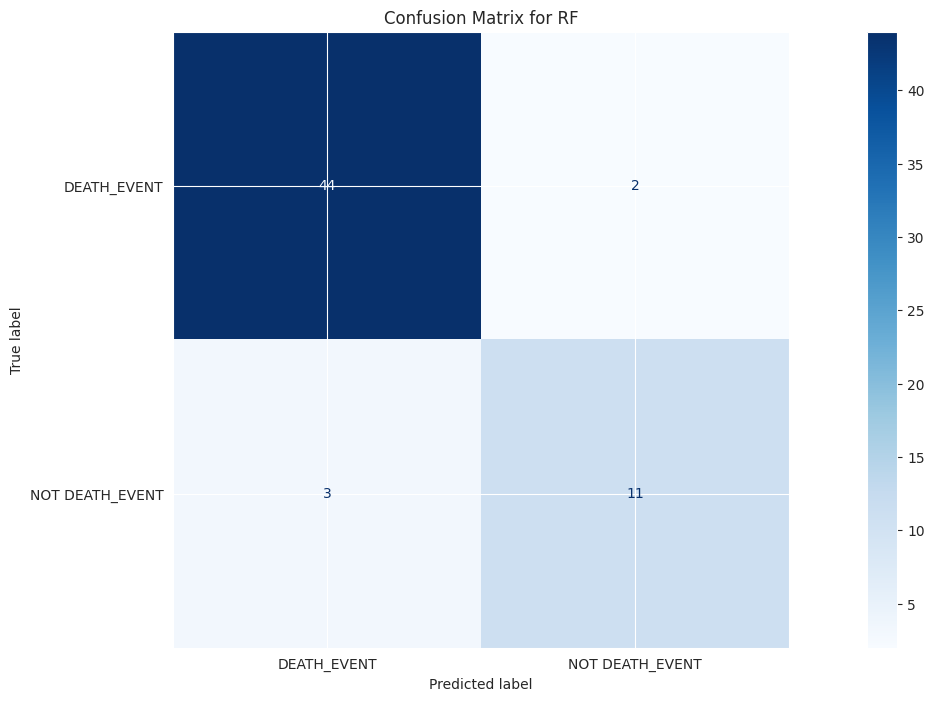

In [755]:
# Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, yr_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['DEATH_EVENT', 'NOT DEATH_EVENT'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title('Confusion Matrix for RF')
plt.show()

#### For RF, although accuracy = 92%. However is has some False Negative (2) cases.

# Conclusion

#### In conclusion, heart attack prediction is very crucial. For the given medical dataset, after analyzing the dataset, 3 models has developed. Alll three models performed well with 93% accuracy for KNN, 87% accuracy for DT and 92% accuracy for RF. However, considering the accuracy and False negarive cases (from confusion matrix), KNN performed best as it achieves highest accuracy with no False negative cases.